# Step 01 # Install the Ultralytics Package

In [ ]:
!nvidia-smi
!pip install ultralytics
!pip install roboflow

Fri Jul 18 03:30:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Step 02 # Import All the Requried Libraries

In [ ]:
# Import libraries
import ultralytics
import cv2
from ultralytics import YOLO
from roboflow import Roboflow
import os
import yaml
import numpy as np
import torch
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from IPython.display import Image, display
from collections import defaultdict

# Check Ultralytics setup
ultralytics.checks()

Ultralytics 8.3.167 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6411.5/8062.4 GB disk)


# Step # 03 Download Dataset from Roboflow

In [ ]:
# Set Roboflow API Key (gunakan API key Anda sendiri di Kaggle)

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="7gl1l1VlS8fxigKprJky")
project = rf.workspace("detection-e83li").project("smokeandfire")
version = project.version(2)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to smokeandfire-2 in yolov11:: 100%|██████████| 19708/19708 [00:02<00:00, 8611.59it/s] 


In [ ]:
dataset.location

'/kaggle/working/smokeandfire-2'

# Path correction

In [ ]:
# Update data.yaml paths
file_path = f'{dataset.location}/data.yaml'
with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

base_path = dataset.location
data['train'] = f"{base_path}/train/images"
data['val'] = f"{base_path}/valid/images"
data['test'] = f"{base_path}/test/images"

with open(file_path, 'w') as file:
    yaml.safe_dump(data, file, default_flow_style=False)

print("Paths updated successfully!")

Paths updated successfully!


# Verification

In [ ]:
from pprint import pprint
with open(file_path, 'r') as file:
    updated_data = yaml.safe_load(file)
    pprint(updated_data)

{'names': ['Fire', 'Smoke'],
 'nc': 2,
 'roboflow': {'license': 'CC BY 4.0',
              'project': 'smokeandfire',
              'url': 'https://universe.roboflow.com/detection-e83li/smokeandfire/dataset/2',
              'version': 2,
              'workspace': 'detection-e83li'},
 'test': '/kaggle/working/smokeandfire-2/test/images',
 'train': '/kaggle/working/smokeandfire-2/train/images',
 'val': '/kaggle/working/smokeandfire-2/valid/images'}


# Labels Clearning

In [ ]:
def read_yolo_annotations_with_metadata(dataset_metadata):
    # Extract paths and class names
    train_path = dataset_metadata['train'].replace('images', 'labels')
    val_path = dataset_metadata['val'].replace('images', 'labels')
    test_path = dataset_metadata['test'].replace('images', 'labels')
    class_names = dataset_metadata['names']

    # Storage variables
    split_stats = {
        'train': defaultdict(int),
        'val': defaultdict(int),
        'test': defaultdict(int)
    }

    def process_labels(label_dir, split_name):
        for label_file in os.listdir(label_dir):
            if not label_file.endswith(".txt"):
                continue

            label_path = os.path.join(label_dir, label_file)

            # Read annotations
            with open(label_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]

            # Find present classes
            present_classes = set()
            for line in lines:
                class_id = int(line.strip().split()[0])
                present_classes.add(class_id)

            # Update counts
            if 0 in present_classes and 1 in present_classes:
                split_stats[split_name]['both'] += 1
            elif 0 in present_classes:
                split_stats[split_name]['fire_only'] += 1
            elif 1 in present_classes:
                split_stats[split_name]['smoke_only'] += 1
            else:
                split_stats[split_name]['background'] += 1

    # Process all datasets
    process_labels(train_path, 'train')
    process_labels(val_path, 'val')
    process_labels(test_path, 'test')

    return {
        'class_stats': split_stats,
        'class_names': class_names
    }

# Example usage
dataset_metadata = {
    'names': ['Fire', 'Smoke'],
    'nc': 2,
     'test': '/kaggle/working/smokeandfire-2/test/images',
     'train': '/kaggle/working/smokeandfire-2/train/images',
     'val': '/kaggle/working/smokeandfire-2/valid/images'
}

results = read_yolo_annotations_with_metadata(dataset_metadata)

# Print the report
print("Fire/Smoke Distribution Across Splits:\n")
for split in ['train', 'val', 'test']:
    stats = results['class_stats'][split]
    total = sum(stats.values())
    print(f"{split.upper()} SET ({total} images)")
    print(f"- Fire only: {stats['fire_only']} ({stats['fire_only']/total:.1%})")
    print(f"- Smoke only: {stats['smoke_only']} ({stats['smoke_only']/total:.1%})")
    print(f"- Both present: {stats['both']} ({stats['both']/total:.1%})")
    print(f"- Background (neither): {stats['background']} ({stats['background']/total:.1%})")
    print()

Fire/Smoke Distribution Across Splits:

TRAIN SET (8243 images)
- Fire only: 4447 (53.9%)
- Smoke only: 1539 (18.7%)
- Both present: 2246 (27.2%)
- Background (neither): 11 (0.1%)

VAL SET (1062 images)
- Fire only: 500 (47.1%)
- Smoke only: 200 (18.8%)
- Both present: 359 (33.8%)
- Background (neither): 3 (0.3%)

TEST SET (543 images)
- Fire only: 352 (64.8%)
- Smoke only: 14 (2.6%)
- Both present: 176 (32.4%)
- Background (neither): 1 (0.2%)



In [ ]:
DATA_YAML_PATH = '/kaggle/working/smokeandfire-2/data.yaml'

print(f"Membaca file konfigurasi dari: {DATA_YAML_PATH}")

if os.path.exists(DATA_YAML_PATH):
    # Buka dan baca file YAML
    with open(DATA_YAML_PATH, 'r') as f:
        data = yaml.safe_load(f)

    print(f"Konfigurasi awal (nc={data.get('nc')}, names={data.get('names')})")

    # Hapus 'background' dari daftar nama kelas jika ada
    if 'background' in data['names']:
        data['names'].remove('background')
        print("-> Kelas 'background' telah dihapus dari daftar 'names'.")

    # Perbarui jumlah kelas (nc) agar sesuai
    data['nc'] = len(data['names'])
    print(f"-> Jumlah kelas (nc) telah diperbarui menjadi: {data['nc']}")

    # Tulis kembali perubahan ke file data.yaml
    with open(DATA_YAML_PATH, 'w') as f:
        yaml.dump(data, f, sort_keys=False)

    print("\n✅ File data.yaml telah berhasil diperbaiki dan disimpan.")
    print(f"Konfigurasi akhir (nc={data.get('nc')}, names={data.get('names')})")
else:
    print(f"❌ ERROR: File {DATA_YAML_PATH} tidak ditemukan. Pastikan sel download data sudah dijalankan.")

Membaca file konfigurasi dari: /kaggle/working/smokeandfire-2/data.yaml
Konfigurasi awal (nc=2, names=['Fire', 'Smoke'])
-> Jumlah kelas (nc) telah diperbarui menjadi: 2

✅ File data.yaml telah berhasil diperbaiki dan disimpan.
Konfigurasi akhir (nc=2, names=['Fire', 'Smoke'])


# Step # 04 Train YOLO11 Model on a Custom Dataset

In [ ]:
!yolo task=detect mode=train model=yolo11s.pt data='{dataset.location}/data.yaml' epochs=30 imgsz=640 plots=True

100%|███████████████████████████████████████| 18.4M/18.4M [00:00<00:00, 134MB/s]
Ultralytics 8.3.167 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/smokeandfire-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimi

# Step # 05 Examine Training Results

In [ ]:
# Import library yang diperlukan
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ultralytics import YOLO
import yaml

print("Memulai analisis performa model...")

# --- Bagian A: Muat Model dan Data ---
try:
    # Path ke model terbaik dari sesi pelatihan terakhir Anda
    model_path = "/kaggle/working/runs/detect/train/weights/best.pt"
    model = YOLO(model_path)

    # Path ke file data.yaml Anda
    # Pastikan variabel 'dataset' dari kode sebelumnya masih ada
    data_yaml_path = f'{dataset.location}/data.yaml'

    print(f"Model '{model_path}' dan data '{data_yaml_path}' berhasil dimuat.")

    # --- Bagian B: Jalankan Validasi dan Ekstrak Matrix ---
    print("\nMenjalankan validasi pada data 'test' untuk mendapatkan metrik...")
    validator = model.val(data=data_yaml_path, imgsz=640, split='test', conf=0.25)

    confusion_matrix_full = validator.confusion_matrix.matrix
    class_names = model.names
    num_classes = len(class_names)

    # Ambil matriks 2x2 (Fire, Smoke)
    cm_2x2 = confusion_matrix_full[:num_classes, :num_classes]
    class_names_2x2 = [class_names[i] for i in range(num_classes)]

    print("Validasi selesai. Matriks 2x2 berhasil diekstrak.")

    # --- Bagian C: Analisis dan Laporan Per Kelas (dengan F1-Score) ---
    print("\n" + "="*45)
    print("      LAPORAN PERFORMA PER KELAS (TERMASUK F1)")
    print("="*45)

    # Iterasi melalui setiap kelas untuk membuat laporan
    for i, name in enumerate(class_names_2x2):
        # TP (True Positive): Prediksi benar sesuai kelasnya
        tp = cm_2x2[i, i]

        # FN (False Negative): Gagal deteksi (diprediksi sbg kelas lain)
        fn = cm_2x2[i, :].sum() - tp

        # FP (False Positive): Salah deteksi (kelas lain diprediksi sbg kelas ini)
        fp = cm_2x2[:, i].sum() - tp

        total_actual = tp + fn

        # Recall (Sensitivity): Seberapa baik model mengenali kelas ini?
        recall = tp / total_actual if total_actual > 0 else 0

        # Precision: Dari semua yang diprediksi sbg kelas ini, berapa yg benar?
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0

        # --- BARIS BARU: HITUNG F1-SCORE ---
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"\n--- Analisis Kelas: '{name}' ---")
        print(f"Total Sampel Asli          : {total_actual} gambar")
        print(f"  > Benar Terdeteksi       : {tp} (True Positive)")
        print(f"  > Gagal Terdeteksi       : {fn} (False Negative)")

        # Detail kesalahan (jika ada)
        if fn > 0:
            for j, other_class in enumerate(class_names_2x2):
                if i != j and cm_2x2[i, j] > 0:
                    print(f"    - {cm_2x2[i, j]} gambar '{name}' salah dideteksi sebagai '{other_class}'")

        print(f"\n> Akurasi Deteksi (Recall) : {recall:.2%}")
        print(f"> Presisi Prediksi (Precision): {precision:.2%}")
        # --- BARIS BARU: TAMPILKAN F1-SCORE ---
        print(f"> F1-Score                 : {f1_score:.2%}")

    print("\n" + "="*45)
    print("Analisis selesai.")

except Exception as e:
    print(f"\nTerjadi kesalahan: {e}")
    print("Pastikan Anda telah menjalankan sel pelatihan sebelumnya dan path file sudah benar.")

Memulai analisis performa model...
Model '/kaggle/working/runs/detect/train/weights/best.pt' dan data '/kaggle/working/smokeandfire-2/data.yaml' berhasil dimuat.

Menjalankan validasi pada data 'test' untuk mendapatkan metrik...
Ultralytics 8.3.167 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 450.9±230.4 MB/s, size: 17.8 KB)


val: Scanning /kaggle/working/smokeandfire-2/test/labels... 543 images, 1 backgrounds, 0 corrupt: 100%|██████████| 543/543 [00:00<00:00, 1435.06it/s]

val: New cache created: /kaggle/working/smokeandfire-2/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:07<00:00,  4.62it/s]
invalid value encountered in less
invalid value encountered in less


                   all        543       1065      0.933      0.874      0.911      0.829
                  Fire        528        748      0.945       0.95      0.962       0.84
                 Smoke        190        317      0.921      0.798       0.86      0.817
Speed: 0.4ms preprocess, 8.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val
Validasi selesai. Matriks 2x2 berhasil diekstrak.

      LAPORAN PERFORMA PER KELAS (TERMASUK F1)

--- Analisis Kelas: 'Fire' ---
Total Sampel Asli          : 726.0 gambar
  > Benar Terdeteksi       : 722.0 (True Positive)
  > Gagal Terdeteksi       : 4.0 (False Negative)
    - 4.0 gambar 'Fire' salah dideteksi sebagai 'Smoke'

> Akurasi Deteksi (Recall) : 99.45%
> Presisi Prediksi (Precision): 99.59%
> F1-Score                 : 99.52%

--- Analisis Kelas: 'Smoke' ---
Total Sampel Asli          : 263.0 gambar
  > Benar Terdeteksi       : 260.0 (True Positive)
  > Gagal Terdeteksi       : 3.0 (False Negative)
 


Menampilkan plot visual...


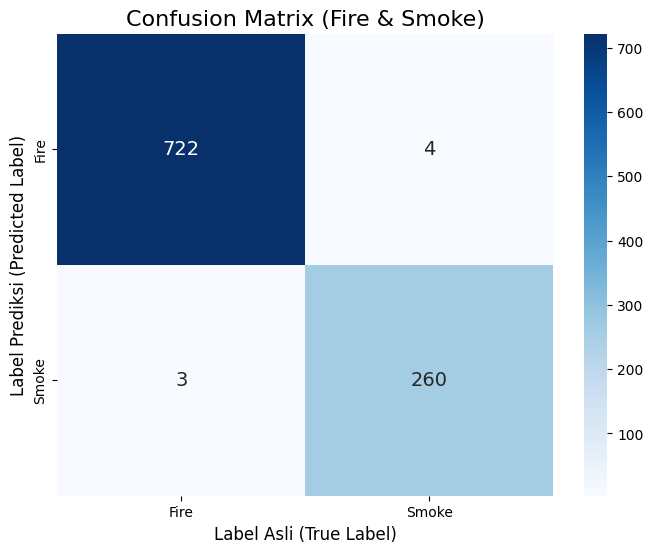

In [ ]:
# --- Bagian D: Visualisasi (Plot Confusion Matrix) ---
print("\nMenampilkan plot visual...")

# Plot Matriks Aktual
plt.figure(figsize=(8, 6))
df_cm = pd.DataFrame(cm_2x2, index=class_names_2x2, columns=class_names_2x2)
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 14})
plt.title('Confusion Matrix (Fire & Smoke)', fontsize=16)
plt.xlabel('Label Asli (True Label)', fontsize=12)
plt.ylabel('Label Prediksi (Predicted Label)', fontsize=12)
plt.show()

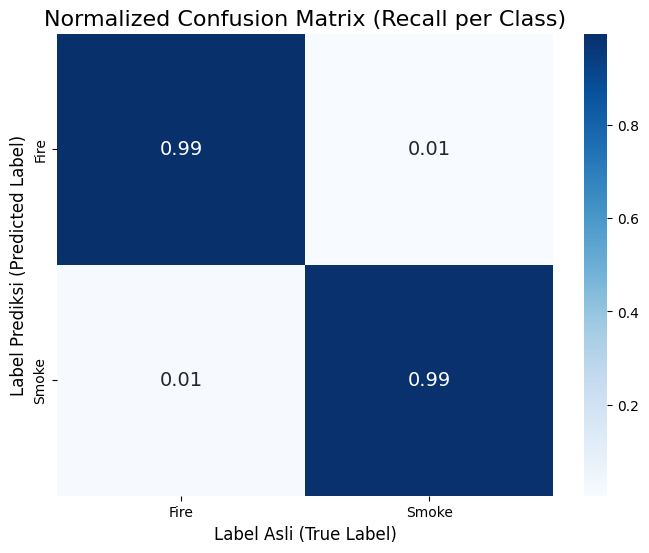

In [ ]:
# Plot Matriks Ternormalisasi (berdasarkan Recall)
normalized_matrix = cm_2x2.astype('float') / np.where(cm_2x2.sum(axis=1)[:, np.newaxis] == 0, 1, cm_2x2.sum(axis=1)[:, np.newaxis])
plt.figure(figsize=(8, 6))
df_cm_normalized = pd.DataFrame(normalized_matrix, index=class_names_2x2, columns=class_names_2x2)
sns.heatmap(df_cm_normalized, annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 14})
plt.title('Normalized Confusion Matrix (Recall per Class)', fontsize=16)
plt.xlabel('Label Asli (True Label)', fontsize=12)
plt.ylabel('Label Prediksi (Predicted Label)', fontsize=12)
plt.show()

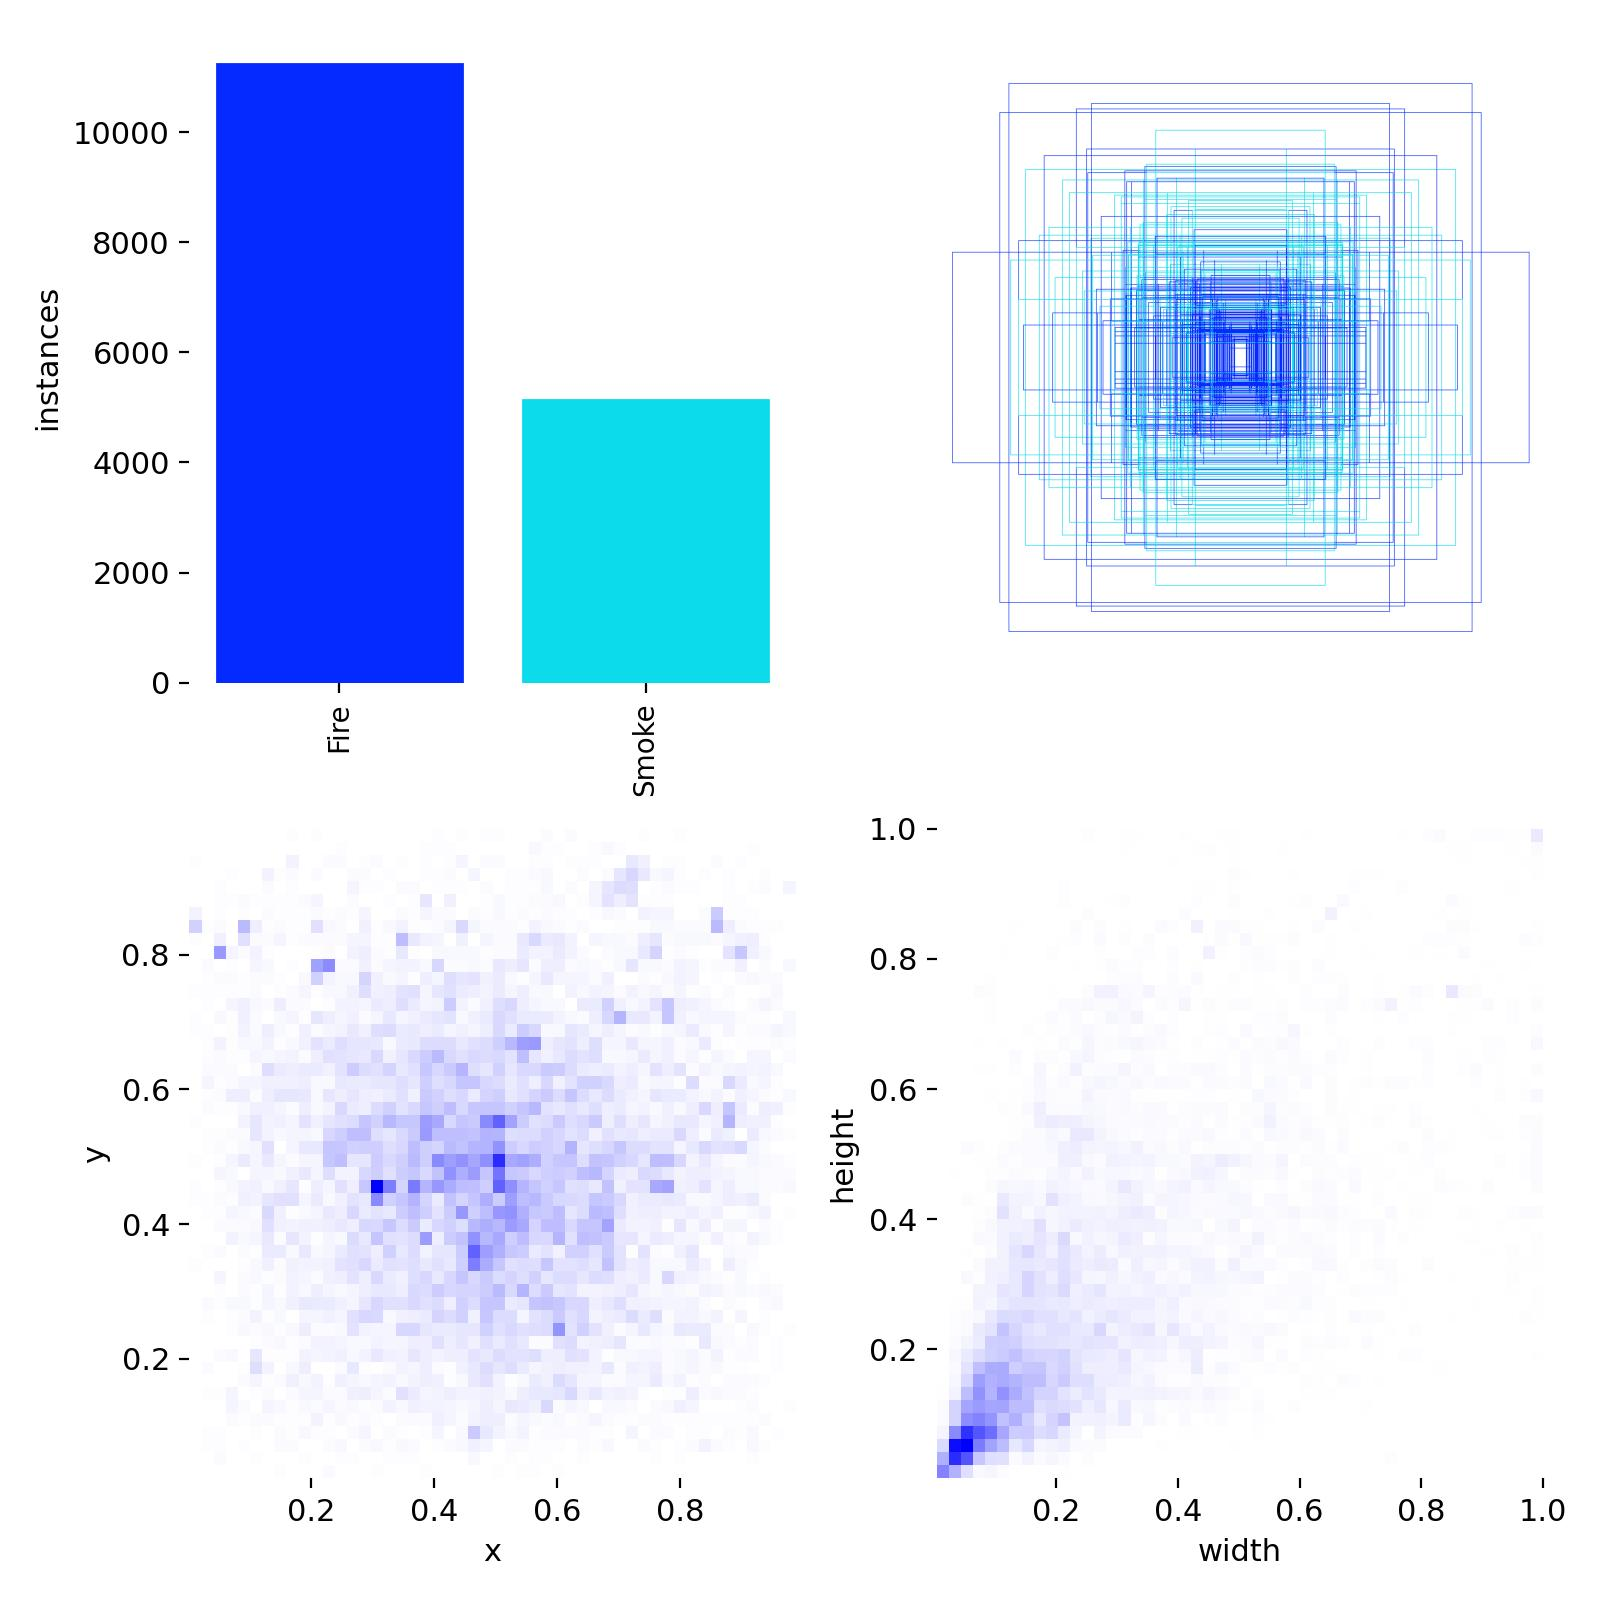

In [ ]:
Image("/kaggle/working/runs/detect/train/labels.jpg", width=600)

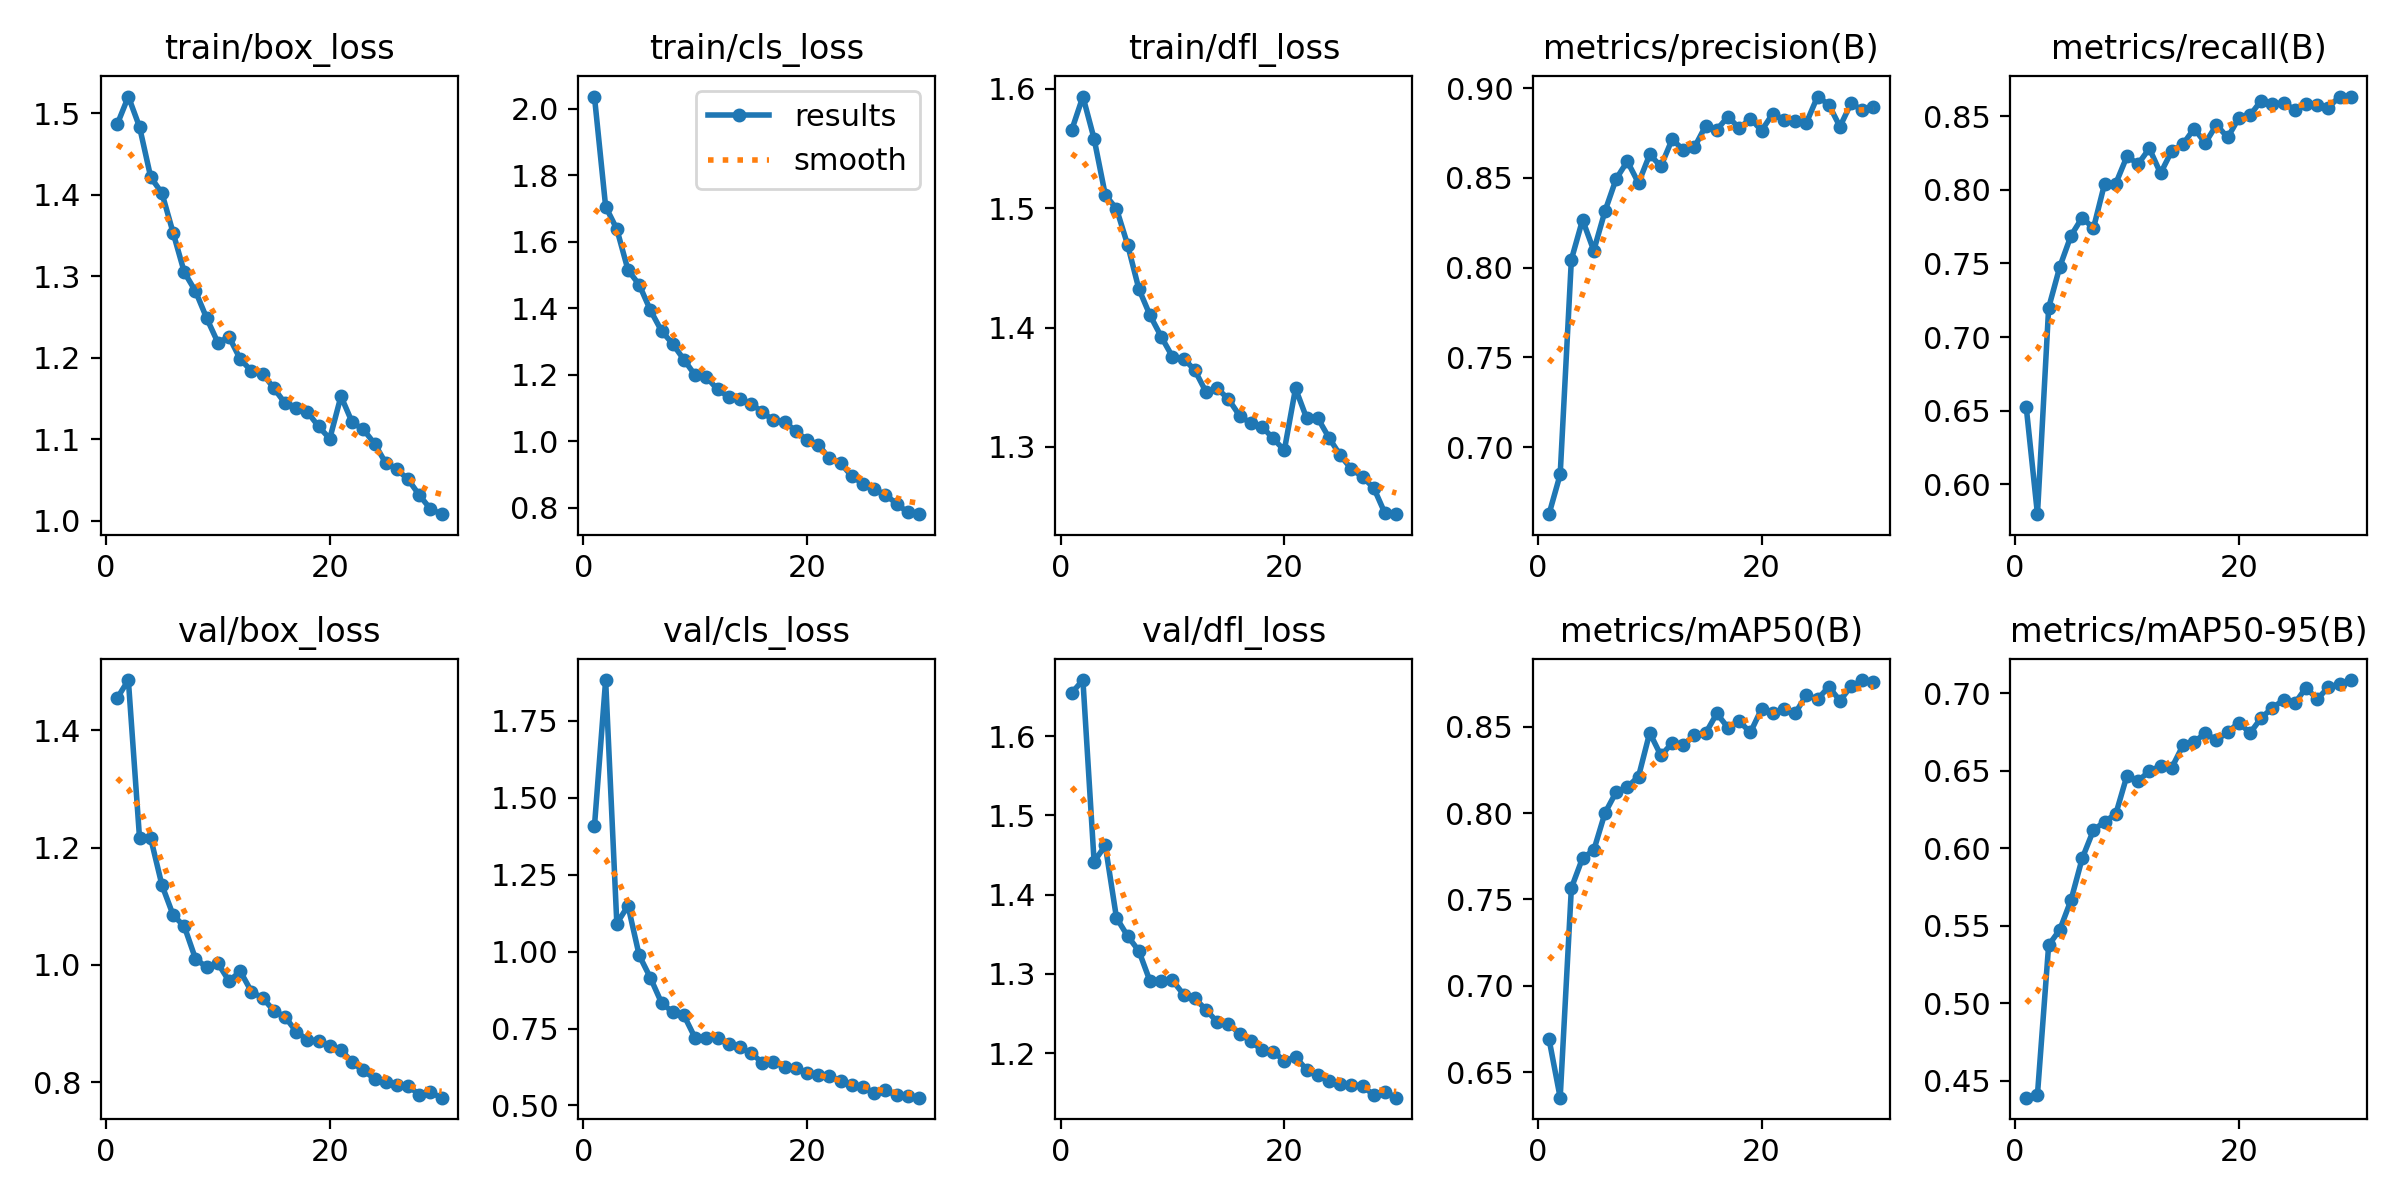

In [ ]:
Image("/kaggle/working/runs/detect/train/results.png", width=600)

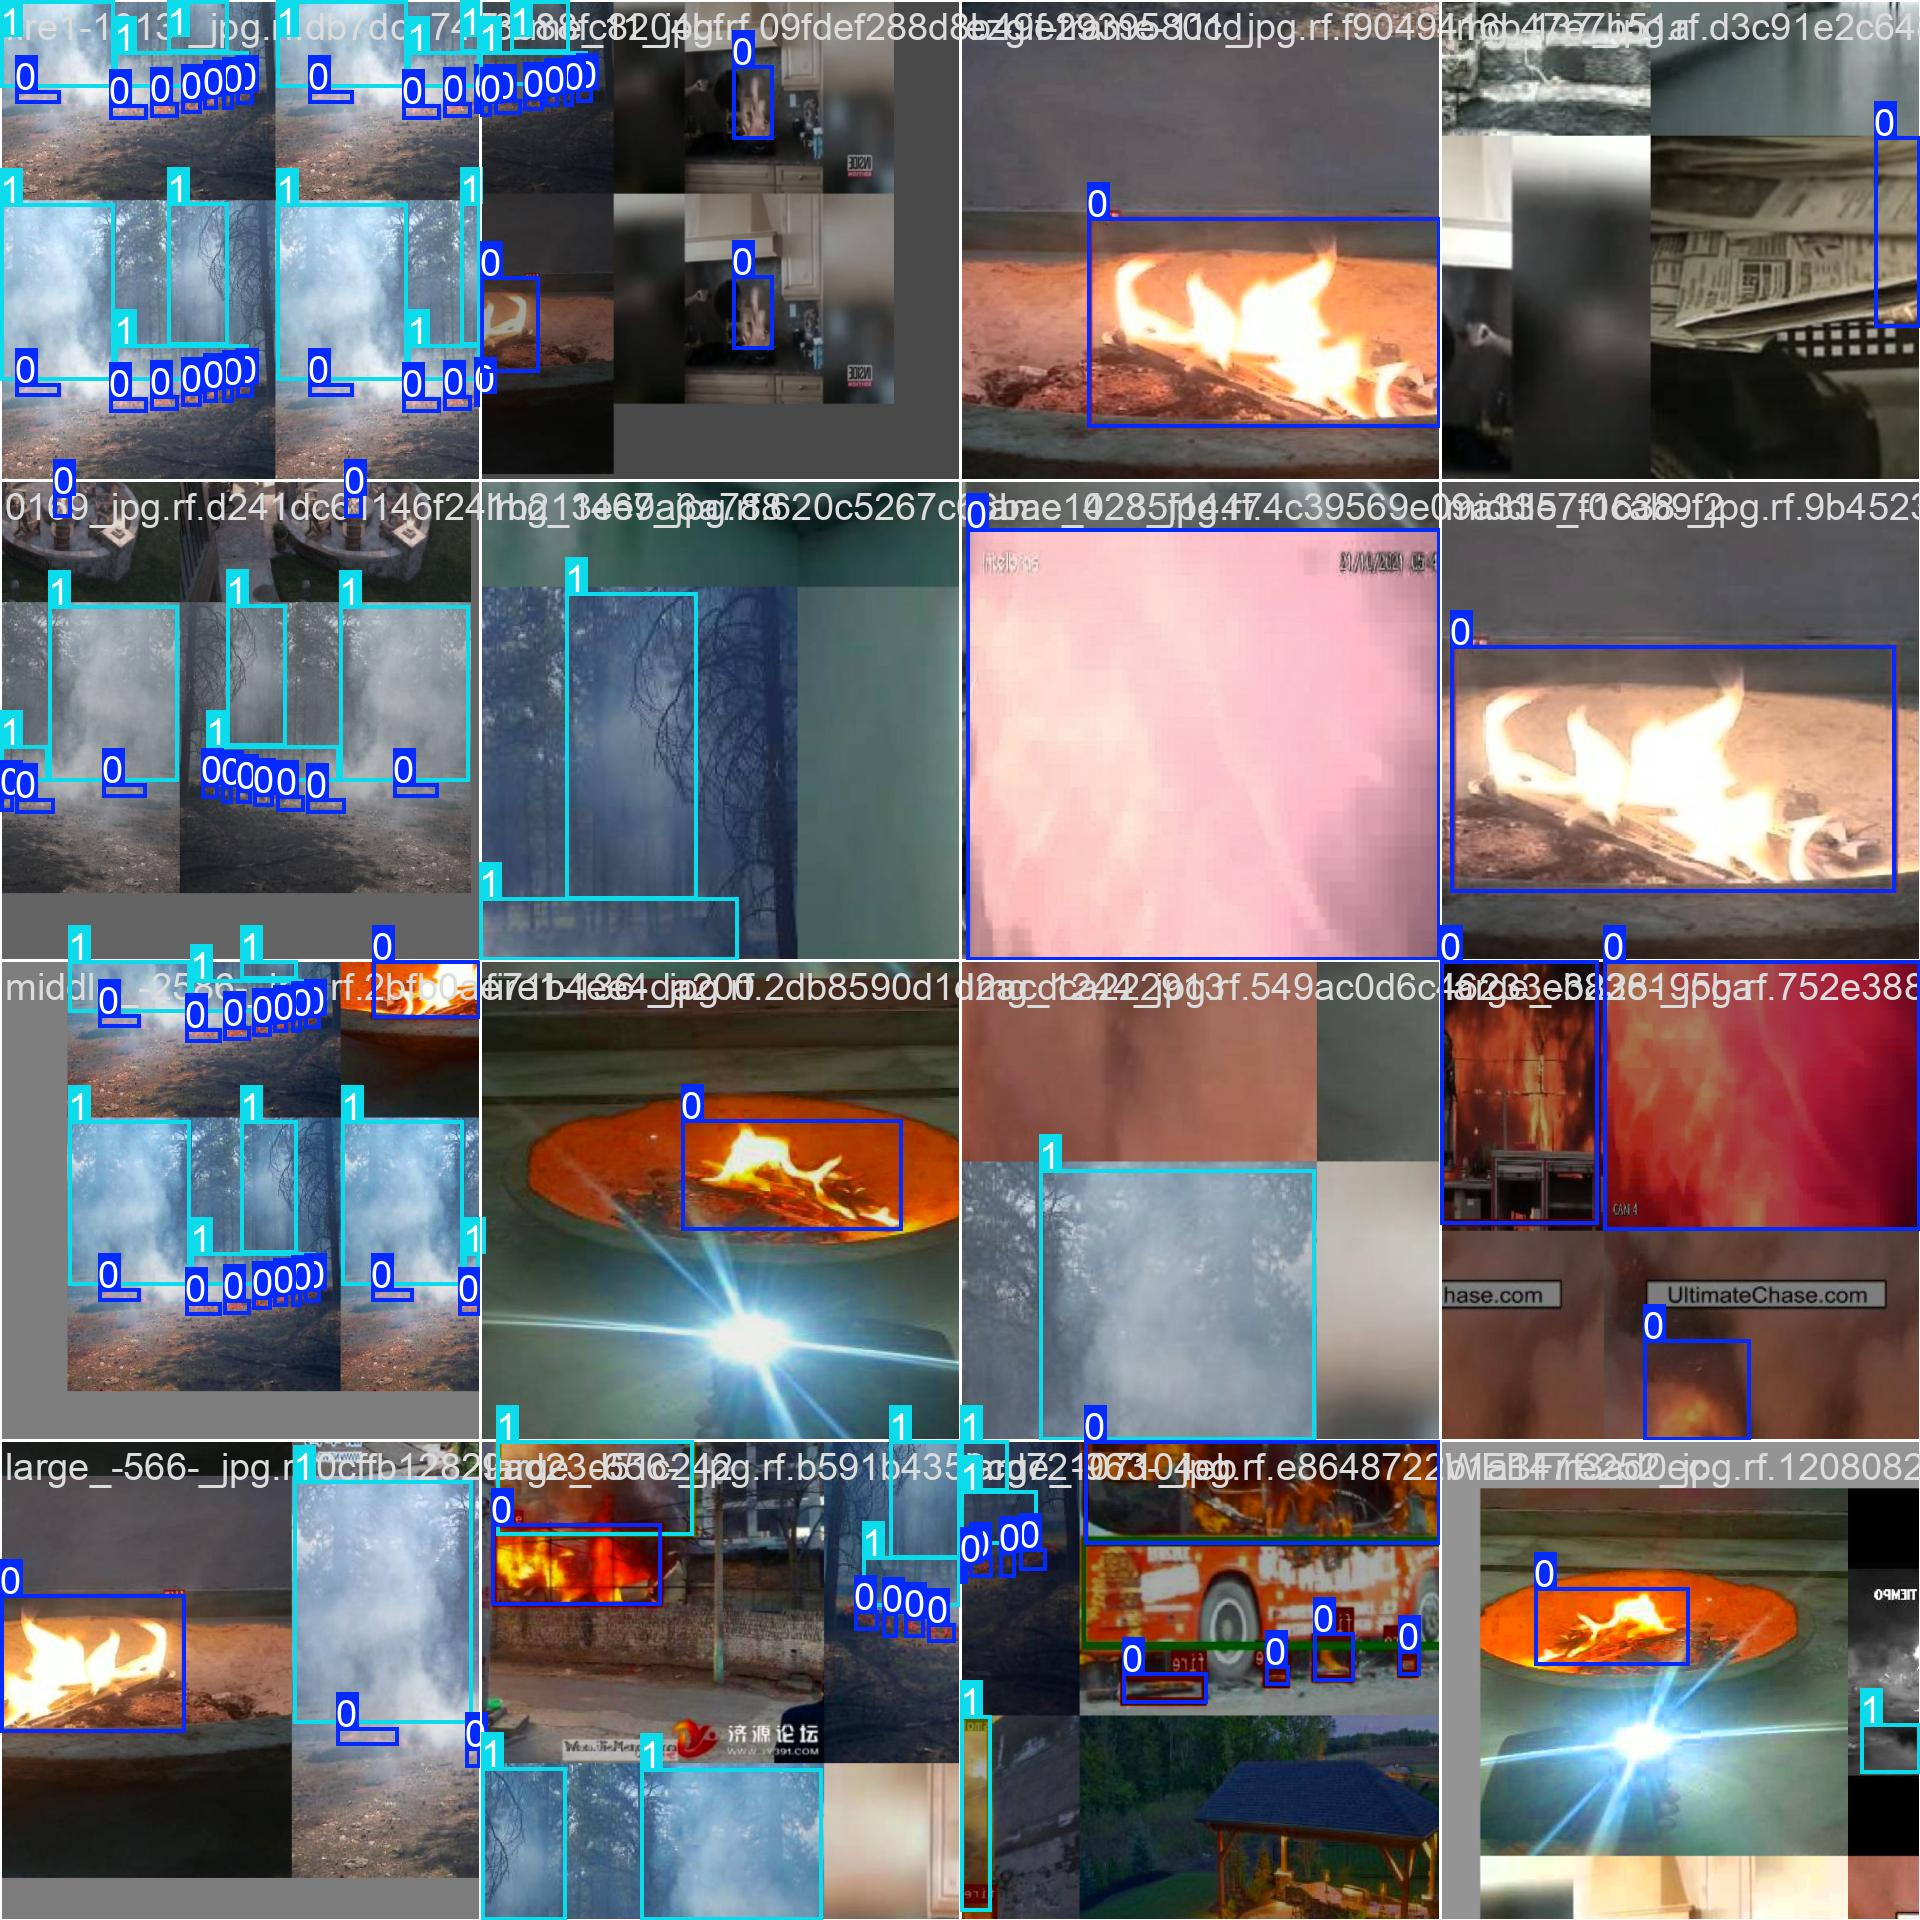

In [ ]:
Image("/kaggle/working/runs/detect/train/train_batch0.jpg", width=600)

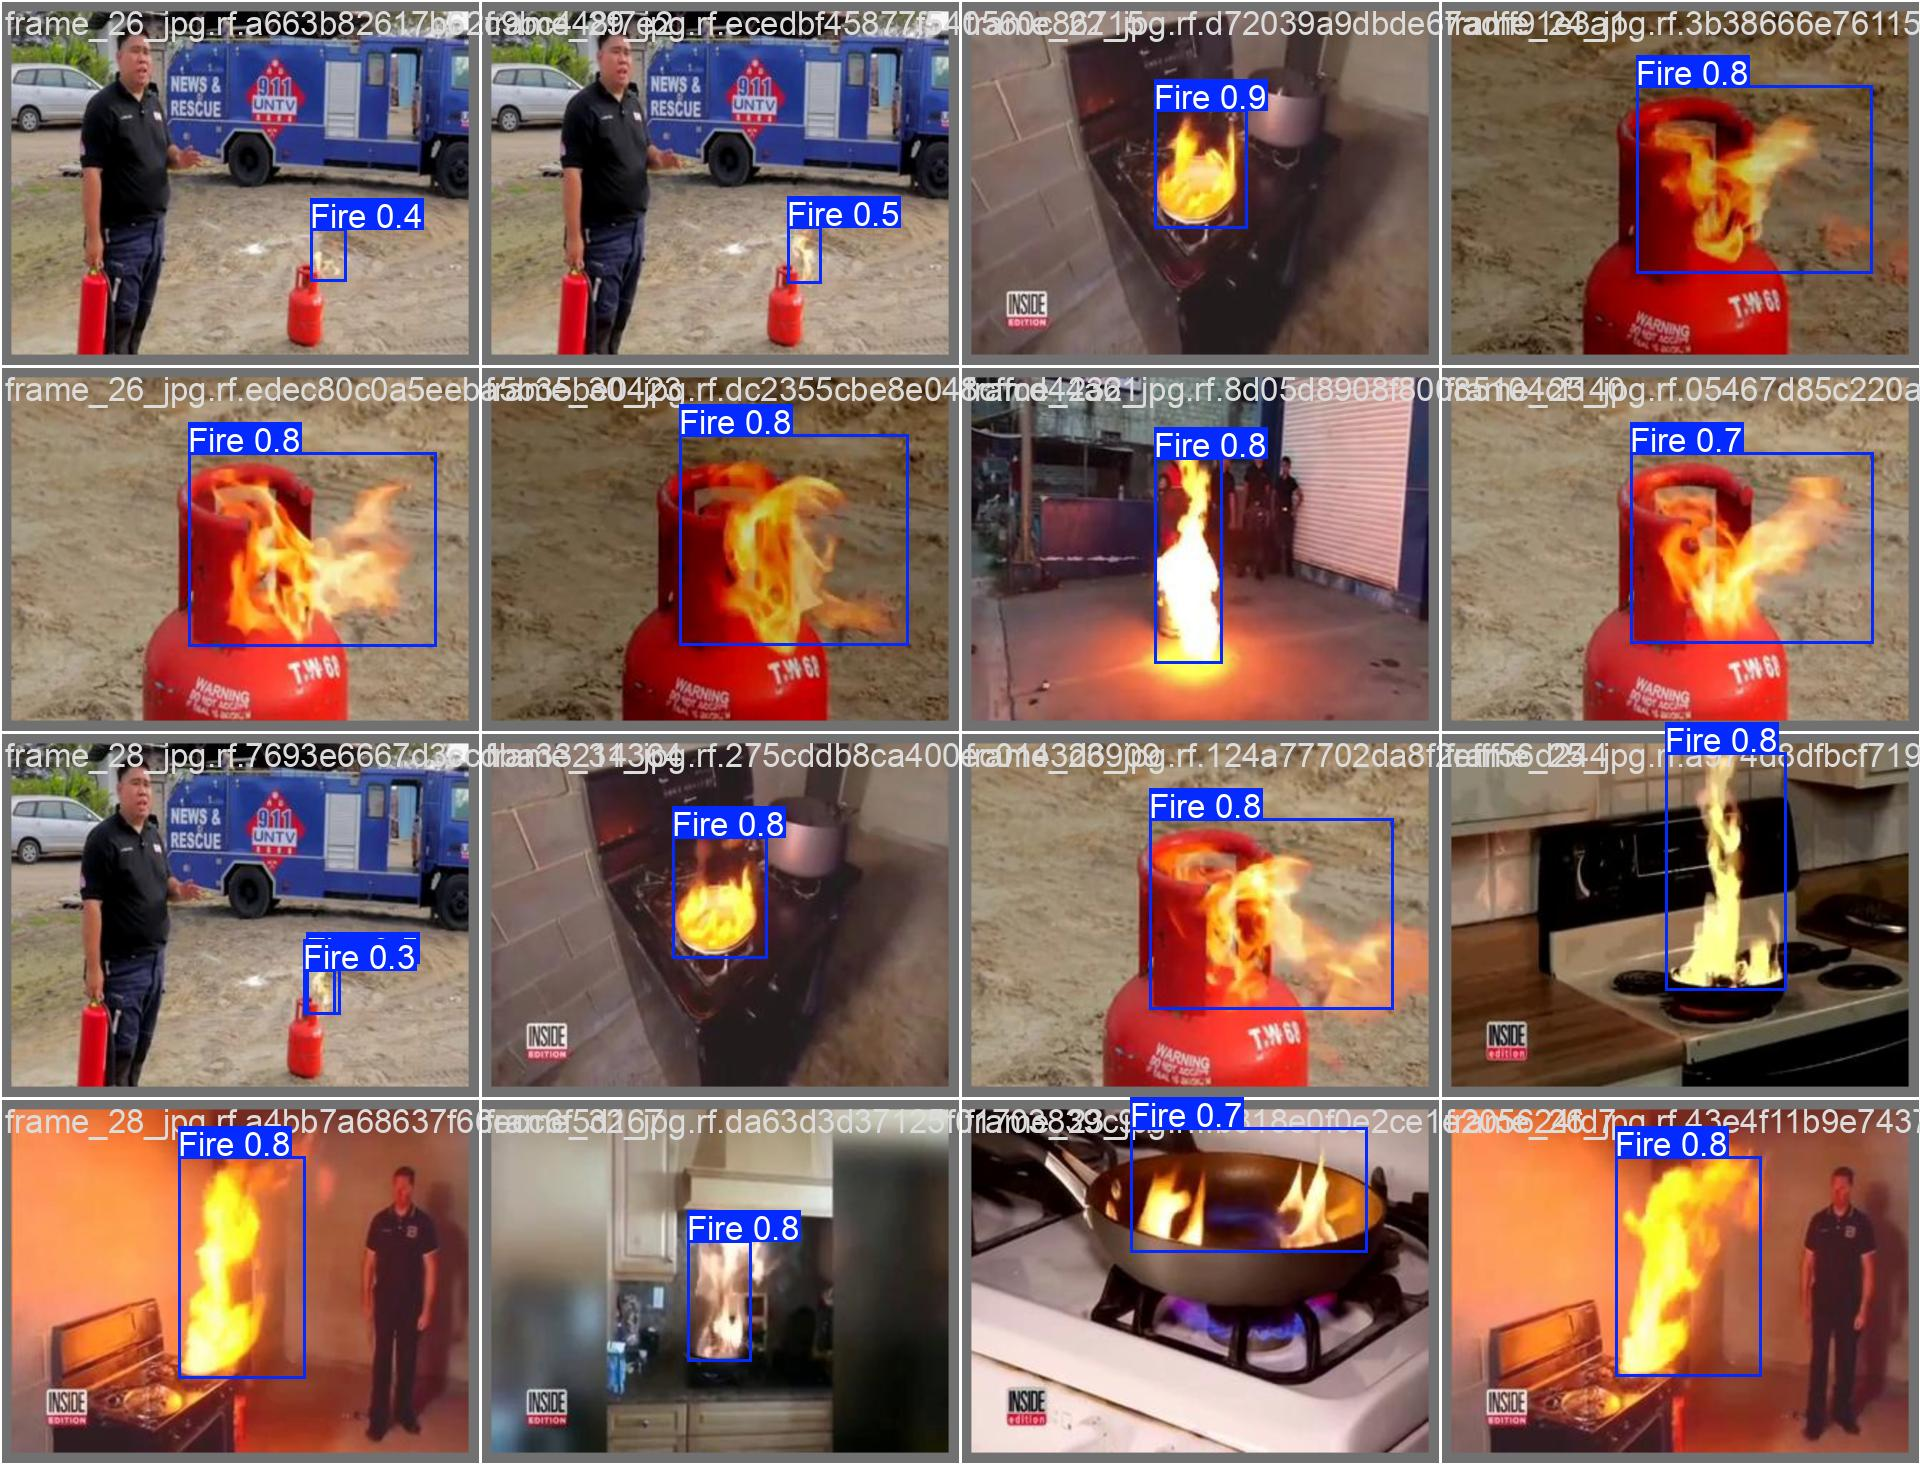

In [ ]:
Image("/kaggle/working/runs/detect/train/val_batch0_pred.jpg", width=600)

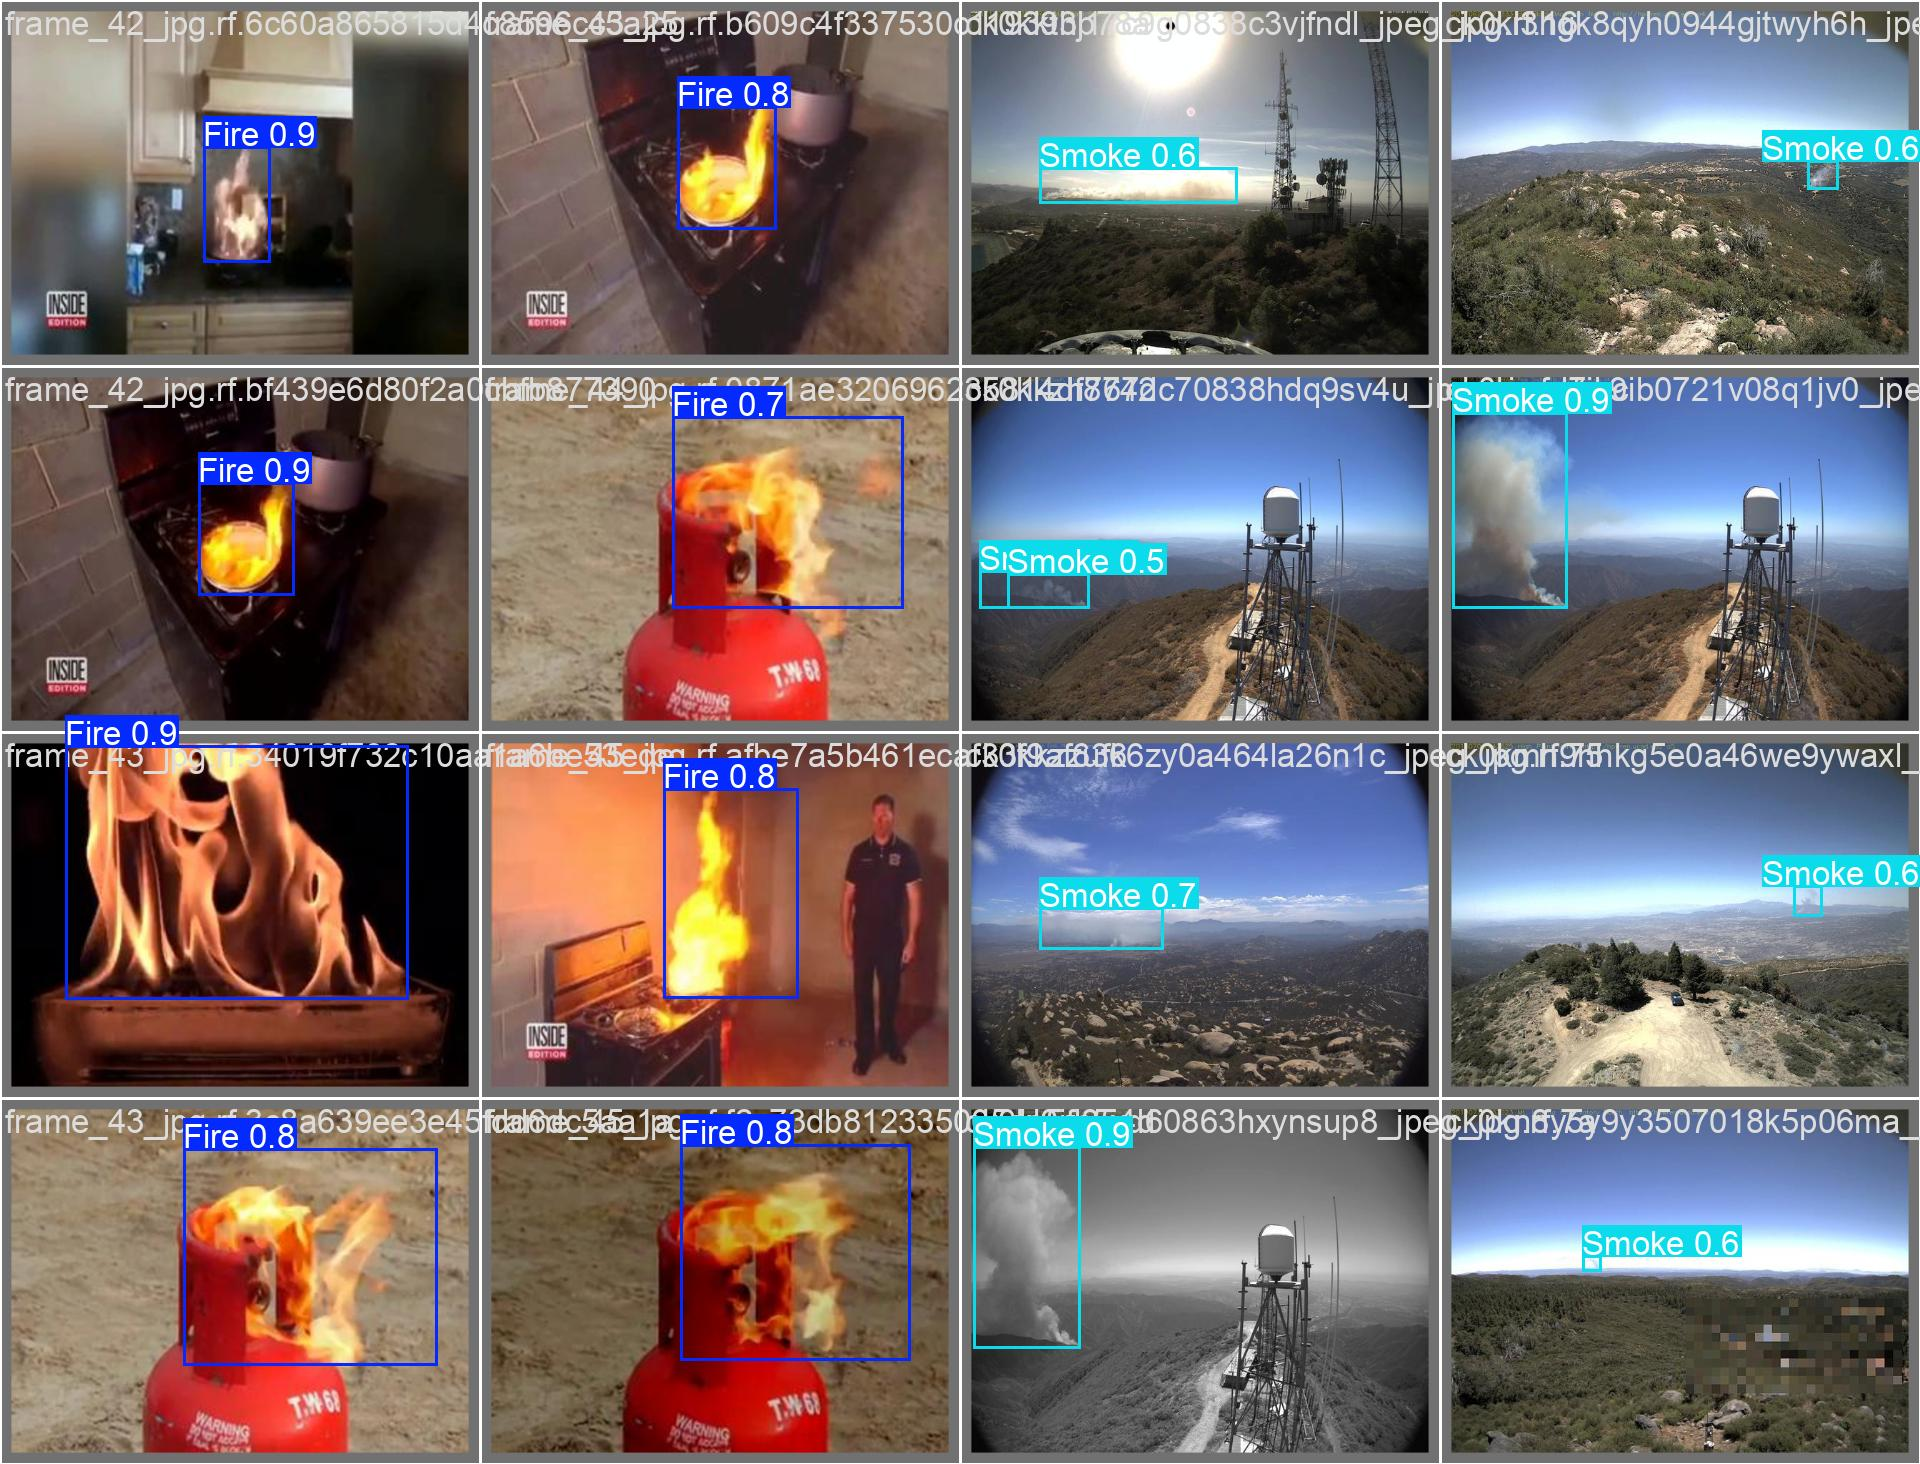

In [ ]:
Image("/kaggle/working/runs/detect/train/val_batch1_pred.jpg", width=600)

# Step # 07 Validate Fine-Tuned Model

In [ ]:
!yolo task=detect mode=val model="/kaggle/working/runs/detect/train/weights/best.pt" data={dataset.location}/data.yaml

Ultralytics 8.3.167 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1174.4±413.7 MB/s, size: 35.5 KB)
val: Scanning /kaggle/working/smokeandfire-2/valid/labels.cache... 1062 images, 
                 Class     Images  Instances      Box(P          R      mAP50  m
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
                   all       1062       2081      0.891      0.864      0.876      0.709
                  Fire        859       1320      0.909      0.935      0.933      0.763
                 Smoke        559        761      0.872      0.792       0.82      0.655
Speed: 0.2ms preprocess, 9.1ms inference, 0.0ms loss

# Step # 08 Inference with Custom Model on Images

In [ ]:
!yolo task=detect mode=predict model="/kaggle/working/runs/detect/train/weights/best.pt" conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.167 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

image 1/543 /kaggle/working/smokeandfire-2/test/images/0055_jpg.rf.09d79673d86d0fa52a1a93305ed458a4.jpg: 640x640 1 Fire, 15.6ms
image 2/543 /kaggle/working/smokeandfire-2/test/images/WEB09331_jpg.rf.2d941bdffa4e11ff7b2cec8066d4c7b8.jpg: 384x640 (no detections), 48.0ms
image 3/543 /kaggle/working/smokeandfire-2/test/images/fire_damage_jpg.rf.838bde4b3b1d858518122e70d47e5571.jpg: 640x640 5 Fires, 16.2ms
image 4/543 /kaggle/working/smokeandfire-2/test/images/fire_jpg.rf.232cadba585833a210940943e54c02f5.jpg: 640x640 1 Fire, 15.5ms
image 5/543 /kaggle/working/smokeandfire-2/test/images/frame_005_jpg.rf.4b798b1474d24f9a332af2f1f4b8e97b.jpg: 480x640 1 Fire, 45.2ms
image 6/543 /kaggle/working/smokeandfire-2/test/images/frame_005_jpg.rf.5cf281ebb6c4f964c7387ace32e4502d.jpg: 480x640 1 Fire, 12.4ms
image 7/543 /kaggle/working/smoke

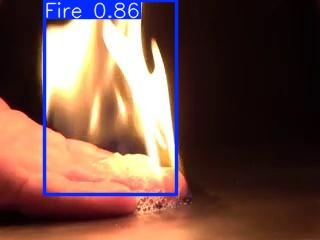

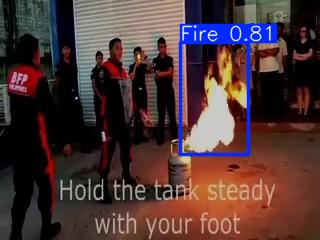

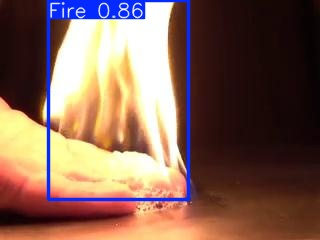

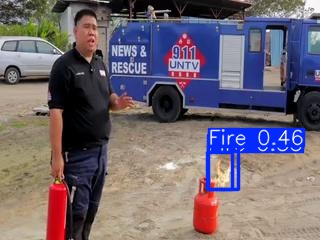

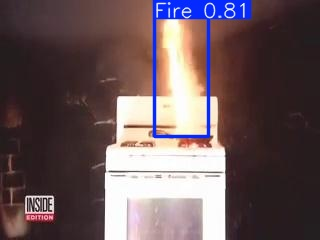

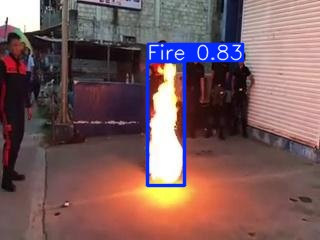

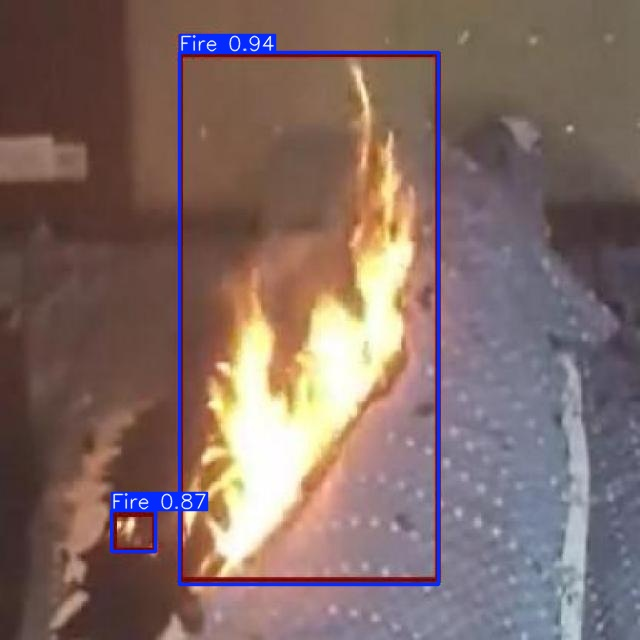

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/kaggle/working/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[1:8]:
    display(IPyImage(filename=img, width=600))
    print("\n")